# Replication for results in Davidson et al. 2017. "Automated Hate Speech Detection and the Problem of Offensive Language"

## Importing Necessary Packages

In [1]:
import matplotlib.pyplot as plt
import re
import sys
import nltk
import string
import seaborn
import numpy as np
import pandas as pd

# Note tqdm import try
try:
    from tqdm.notebook import tqdm
except:
    import tqdm

import textstat
from nltk.stem.porter import *
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS

from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

%matplotlib inline

[nltk_data] Downloading package stopwords to /Users/sam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sam/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Custom imports

Utility functions for Preprocessing and feature engineering

In [2]:
from util.preprocess_log_regr_and_svm import preprocess
from util.preprocess_log_regr_and_svm import tokenize
from util.preprocess_log_regr_and_svm import basic_tokenize
from util.preprocess_log_regr_and_svm import count_twitter_objs
from util.preprocess_log_regr_and_svm import other_features
from util.preprocess_log_regr_and_svm import get_feature_array
from util.preprocess_log_regr_and_svm import generate_features_train_data
from util.preprocess_log_regr_and_svm import generate_features_test_data

[nltk_data] Downloading package stopwords to /Users/sam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sam/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Loading the data

In [3]:
X_train_davidson = pd.read_csv("hate_speech_labelled_data/labeled_data.csv")

X_train_davidson.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


### Columns key:

-   count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).


-   hate_speech = number of CF users who judged the tweet to be hate speech.


-   offensive_language = number of CF users who judged the tweet to be offensive.


-   neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.


-   class = class label for majority of CF users.

    -   0 - hate speech
    -   1 - offensive  language
    -   2 - neither

-   tweet = raw tweet text


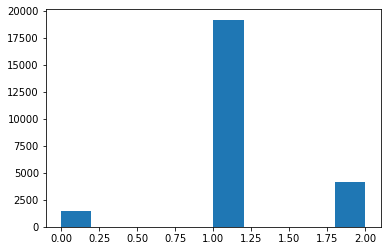

In [4]:
X_train_davidson['class'].hist(grid=False)

This histogram shows the imbalanced nature of the task - most tweets containing "hate" words as defined by Hatebase were 
only considered to be offensive by the CF coders. More tweets were considered to be neither hate speech nor offensive language than were considered hate speech.

# Training the model and testing it

The best model was selected using a GridSearch with 5-fold CV.

In [7]:
X_train_davidson_tweets = X_train_davidson['tweet']
M, vectorizer, pos_vectorizer = generate_features_train_data(X_train_davidson_tweets)

/Users/sam/Downloads/GitHub/covid_19_hate_speech/venv/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
100%|██████████| 24783/24783 [01:11<00:00, 346.63it/s]


In [8]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

X = pd.DataFrame(M)
y = X_train_davidson['class'].astype(int)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [10]:
pipe = Pipeline(
        [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                       penalty="l1", 
                                                       C=0.01, 
                                                       solver='liblinear'))),
        ('model', LinearSVC(class_weight='balanced',C=0.01, penalty='l2', loss='squared_hinge',multi_class='ovr', dual=False, max_iter=10000))])

param_grid = [{}] # Optionally add parameters here
grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True).split(X_train, y_train), 
                           verbose=2)

# Train the Model and optimize with grid search

In [11]:
model = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   7.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s


[CV] ................................................. , total=   7.8s
[CV]  ................................................................
[CV] ................................................. , total=   6.2s
[CV]  ................................................................
[CV] ................................................. , total=   6.0s
[CV]  ................................................................
[CV] ................................................. , total=   7.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.2s finished


## Evaluating the results

***Note: Results in paper are from best model retrained on the entire dataset (see the other notebook). Here the results are reported after using cross-validation and only for the held-out set.***

In [0]:
y_preds = model.predict(X_test)
report = classification_report(y_test, y_preds)
print(report)

              precision    recall  f1-score   support

           0       0.46      0.60      0.52       164
           1       0.96      0.91      0.94      1905
           2       0.82      0.95      0.88       410

    accuracy                           0.89      2479
   macro avg       0.75      0.82      0.78      2479
weighted avg       0.91      0.89      0.90      2479



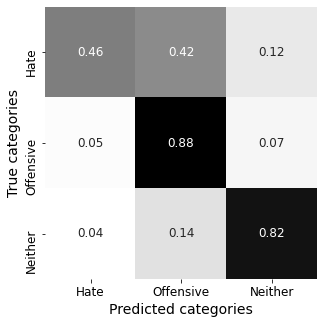

In [13]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))

for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
    
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

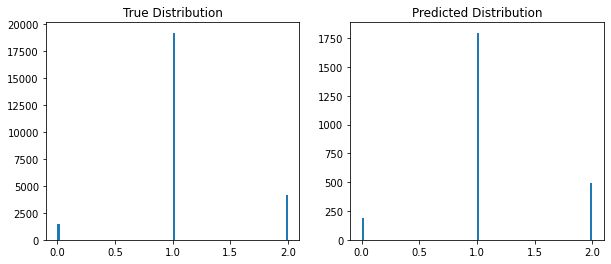

In [14]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(10)

axes[0].set_title('True Distribution')
axes[1].set_title('Predicted Distribution')

y.hist(bins=100, ax=axes[0], grid=False)
pd.Series(y_preds).hist(bins=100, ax=axes[1], grid=False)